# 📊 Who Uses Buy Now, Pay Later (BNPL) in the U.S.?
**Data Source:** Federal Reserve SHED 2023  
**Objective:** Analyze demographic patterns of BNPL usage by age, income, and education using logistic regression.


In [73]:
# Loading Packages
!pip install pyreadstat
!pip install pyreadstat pandas matplotlib seaborn
%matplotlib inline
#Importing Libraries
import pyreadstat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
#Loading Datasets
df, meta = pyreadstat.read_dta("Downloads/public2023.dta")
#list(df.columns)


In [131]:
# Map BNPL usage
df['used_bnpl'] = df['BNPL1'].map({1: 1, 0: 0})

# Map age categories
df['age_group'] = df['ppagect4'].map({
    1: "18–29",
    2: "30–44",
    3: "45–59",
    4: "60+"
})

# Map income categories
df['income_group'] = df['inc_4cat_50k'].map({
    1: "<25K",
    2: "25–50K",
    3: "50–100K",
    4: "100K+"
})

# Map education categories
df['education'] = df['educ_4cat'].map({
    1: "High School or Less",
    2: "Some College",
    3: "Bachelor's",
    4: "Graduate Degree"
})

df.to_csv("cleaned_shed_data.csv", index=False)

# Exploratory Analysis
- Dstribution of usage rates
- BNPL Usage by Demographics
- Cross BNPL use by education & income

In [80]:
# Distribution of People using Buy Now Pay Later Service
df['used_bnpl'].value_counts(normalize=True) * 100

used_bnpl
0    87.236842
1    12.763158
Name: proportion, dtype: float64

Only ~12.8% of your SHED sample reported using a Buy Now, Pay Later (BNPL) service in the past year

## USAGE RATES
The usage rate tells you the percentage of people in a group who said “yes” to using something — in this case, Buy Now, Pay Later (BNPL) services.

In [95]:
#Calculate usage rates
summary = df.groupby(['age_group', 'income_group', 'education'])['used_bnpl'].mean().reset_index()
summary['usage_rate'] = (summary['used_bnpl'] * 100).round(1)


In [97]:
# BNPL usage by Demographics
df.groupby('age_group')['used_bnpl'].mean() * 100
df.groupby('income_group')['used_bnpl'].mean() * 100
df.groupby('education')['used_bnpl'].mean() * 100


education
Bachelor's             15.856844
Graduate Degree        10.379117
High School or Less    14.642857
Some College           12.128146
Name: used_bnpl, dtype: float64

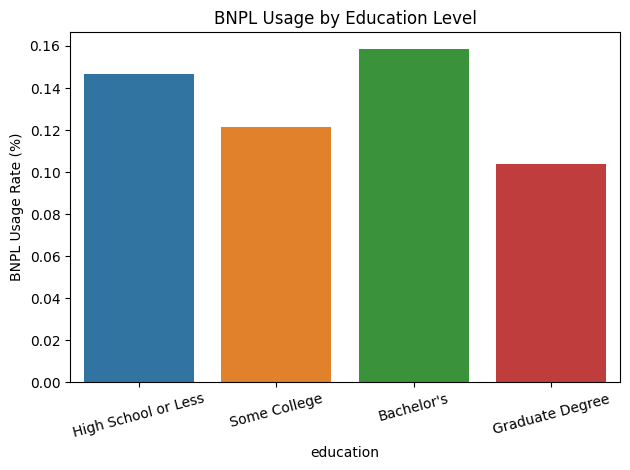

In [99]:
sns.barplot(
    x=df['education'], 
    y=df['used_bnpl'], 
    estimator=np.mean, 
    order=["High School or Less", "Some College", "Bachelor's", "Graduate Degree"],
    errorbar=None  # replaces ci=None
)
plt.ylabel("BNPL Usage Rate (%)")
plt.title("BNPL Usage by Education Level")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



### BNPL Usage by Education: A Surprising Gradient

People with a **Bachelor’s degree** are the most likely to use Buy Now, Pay Later (BNPL), followed closely by those with **only a high school education**.

Surprisingly, **Graduate degree holders** are the least likely to use BNPL.

#### Why might this be?

- **Bachelor’s graduates** may:
  - Be more exposed to e-commerce and digital financial tools
  - Have greater lifestyle expenses
  - Feel more financially autonomous

- **Graduate degree holders** might:
  - Have more stable income
  - Prefer traditional credit options
  - Be more risk-averse

- The **Some College** group often falls in between — navigating between financial empowerment and fragility — and may access BNPL cautiously.


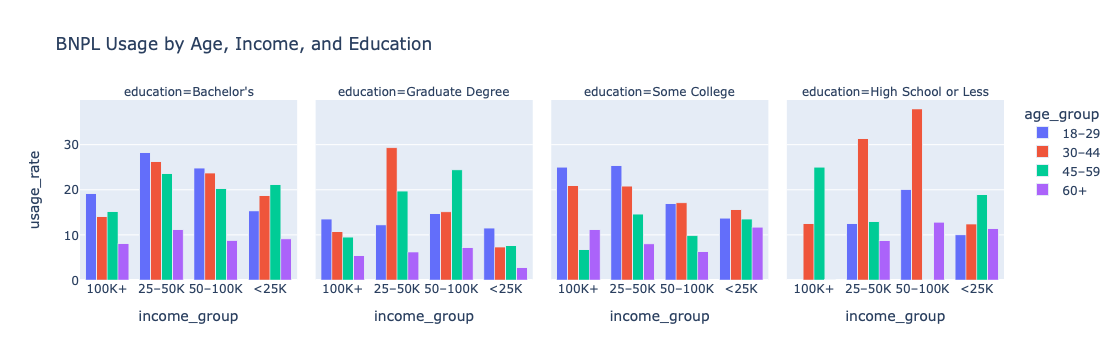

In [102]:
import plotly.express as px
fig = px.bar(
    summary,
    x="income_group", y="usage_rate",
    color="age_group",
    facet_col="education",
    barmode="group",
    title="BNPL Usage by Age, Income, and Education"
)
fig.show()


In [104]:
import statsmodels.formula.api as smf

# C() treats categorical variables properly
model = smf.logit(
    formula="used_bnpl ~ C(age_group) + C(income_group) + C(education)", 
    data=df
).fit()

print(model.summary())


Optimization terminated successfully.
         Current function value: 0.369471
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              used_bnpl   No. Observations:                11400
Model:                          Logit   Df Residuals:                    11390
Method:                           MLE   Df Model:                            9
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                 0.03244
Time:                        18:08:23   Log-Likelihood:                -4212.0
converged:                       True   LL-Null:                       -4353.2
Covariance Type:            nonrobust   LLR p-value:                 1.369e-55
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -1.6745      0.102 

### BNPL Usage: Who’s Most Likely to Use It?
Using data from 11,400 respondents in the Federal Reserve’s SHED survey, we ran a logistic regression to predict who is more or less likely to use Buy Now, Pay Later (BNPL) services. The model shows that BNPL usage is most common among middle-income adults under 60 with a Bachelor’s degree. In contrast, older individuals (60+) and those with Graduate degrees are significantly less likely to use BNPL, highlighting a potential generational and cultural divide in fintech adoption.

In [109]:
#Checking for Multicollinearnity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

y, X = dmatrices("""
    used_bnpl ~ C(age_group) + C(income_group) + C(education)
                + C(ppgender) + C(ppemploy) + C(ppracem) + C(pphispan)
""", data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                               Variable        VIF
0                             Intercept  15.710391
1                 C(age_group)[T.30–44]   2.063665
2                 C(age_group)[T.45–59]   2.161909
3                   C(age_group)[T.60+]   2.740346
4             C(income_group)[T.25–50K]   1.489196
5            C(income_group)[T.50–100K]   1.429209
6               C(income_group)[T.<25K]   1.875847
7       C(education)[T.Graduate Degree]   1.515825
8   C(education)[T.High School or Less]   1.172601
9          C(education)[T.Some College]   1.300496
10                     C(ppgender)[T.2]   1.036761
11                     C(ppemploy)[T.2]   1.252705
12                     C(ppemploy)[T.3]   1.729219
13                      C(ppracem)[T.2]   1.045744
14                      C(ppracem)[T.3]   1.017433
15                      C(ppracem)[T.4]   1.039117
16                      C(ppracem)[T.5]   1.001454
17                      C(ppracem)[T.6]   1.020430
18                     C(pphisp

### Multicollinearity Check: VIF Interpretation

To assess multicollinearity in the logistic regression model, we calculated Variance Inflation Factors (VIF) for all predictor variables.

#### What is VIF?
- VIF measures how much a predictor variable is correlated with other predictors in the model.
- A **VIF > 5** usually signals a multicollinearity issue.
- A **VIF < 3** is generally considered safe.

#### Summary of Findings:
- All predictor variables had **VIFs well below 3**, with most ranging from **1.0 to 2.7**.
- The only high VIF (15.7) appeared on the **Intercept**, which is expected due to dummy coding.
  
#### Conclusion:
- **There is no evidence of multicollinearity** in the model.
- We can confidently interpret the effects of age, income, education, gender, employment, race, and ethnicity on BNPL usage.



In [117]:
# Marginal Effects
mfx = model.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:              used_bnpl
Method:                          dydx
At:                           overall
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(age_group)[T.30–44]                   0.0068      0.009      0.718      0.473      -0.012       0.025
C(age_group)[T.45–59]                  -0.0085      0.010     -0.871      0.384      -0.027       0.011
C(age_group)[T.60+]                    -0.0921      0.010     -9.519      0.000      -0.111      -0.073
C(income_group)[T.25–50K]               0.0595      0.010      6.159      0.000       0.041       0.078
C(income_group)[T.50–100K]              0.0412      0.008      4.945      0.000       0.025       0.058
C(income_group)[T.<25K]                 0.0160      0.011      1.485      0.138      -0.005       0.037
C(education)[T.G

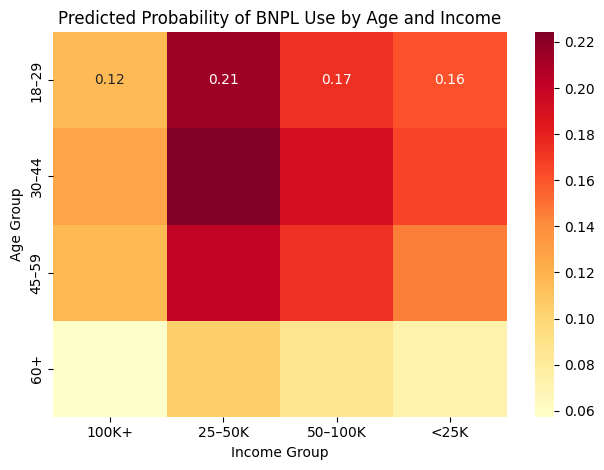

In [59]:
#Preciting Probablities
import seaborn as sns
import matplotlib.pyplot as plt

pivot_data = grouped.pivot(index='age_group', columns='income_group', values='predicted_prob')

sns.heatmap(pivot_data, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Predicted Probability of BNPL Use by Age and Income")
plt.xlabel("Income Group")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


In [63]:
df['predicted_prob'] = model.predict()
grouped = df.groupby(['age_group', 'income_group'])['predicted_prob'].mean().round(2).reset_index()

### Predicted Probability of BNPL Use by Age and Income

The heatmap below illustrates the predicted probability of using Buy Now, Pay Later (BNPL) services based on a respondent’s age group and income bracket. These probabilities are derived from a logistic regression model.

#### Key Takeaways:

- **Peak BNPL usage is among adults aged 30–44 earning $25K–50K**, with a predicted probability of **0.22**.
- BNPL usage tends to **decrease with age**, especially for those aged 60+, regardless of income.
- Across age groups, **middle-income earners ($25K–50K)** consistently show the **highest predicted usage rates**.
- High-income individuals ($100K+) across all age brackets are **less likely to use BNPL**, with probabilities around **0.12 or lower**.

#### Interpretation:

This pattern suggests that BNPL adoption is strongest among younger and middle-aged adults who fall within moderate income brackets. This may reflect greater familiarity with fintech products, combined with limited access to traditional credit or the desire for short-term liquidity.



## 📌 Key Takeaways
- Older adults (60+) are significantly less likely to use BNPL services.
- Mid-income groups ($25K–100K) are the most frequent BNPL users.
- Bachelor's degree holders show the highest usage across education levels.
